# Проект "Маркетинговая аналитика продукта "Афиша"

## Описание проекта

**Задача:** снизить расходы на маркетинг — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

**Необходимо изучить:**
<li> как клиенты пользуются сервисом,
<li> когда делают первые покупки на сайте,
<li> сколько денег приносит компании каждый клиент,
<li> когда расходы на привлечение клиента окупаются.
    
Выручка измеряется в условных единицах — у.е.
       
**Данные:**
    
визиты: /datasets/visits_log.csv 
    
заказы: /datasets/orders_log.csv
    
расходы: /datasets/costs.csv

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 200
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Предобработка датафрейма visits

In [3]:
print(visits.head())
visits.info()
visits.columns

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

Столбцы датафрейма заполнены полностью, у столбцов End Ts и Start Ts не корректный тип. Необходимо эти столбцы привести к типу datetime.
А так же для удобства, переименую столбцы, приведу их названия к нижнему регистру и заменю пробелы.

In [4]:
#переименование столбцов
visits.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], axis = 'columns', inplace = True)
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [5]:
#изменение типов столбцов
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['device'] = pd.Series(visits['device'], dtype="category")

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [7]:
print('Дубликатов в датесете visits: ', visits.duplicated().sum()) 

Дубликатов в датесете visits:  0


### Предобработка датафрейма orders

In [8]:
print(orders.head())
orders.info()
orders.columns

                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

Датафрейм заполнен полностью, столбец Buy Ts имеет не корректный тип, его нобходимо изменить, так же изменю названия столбцов для удобства.

In [9]:
# переименование столбцов
orders.set_axis(['buy_ts', 'revenue', 'uid'], axis = 'columns', inplace = True)
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [10]:
#изменение типа данных
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [12]:
orders.describe()

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [13]:
print('Дубликатов в датесете orders: ', orders.duplicated().sum()) 

Дубликатов в датесете orders:  0


### Предобработка датафрейма costs

In [14]:
print(costs.head())

   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Датафрейм заполнен полоностью, столбец dt имеет не корректный тип.

In [16]:
#изменение типа столбца dt
costs['dt'] = pd.to_datetime(costs['dt'])

In [17]:
#проверка столбца source_id 
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Столбец заполнен корректно

In [18]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [19]:
print('Дубликатов в датесете costs: ', costs.duplicated().sum()) 

Дубликатов в датесете costs:  0


## Расчет метрик и построение графиков

### Расчет продуктовых метрик

#### Рассчет DAU, WAU и MAU. 
DAU  — количество уникальных пользователей в день;

WAU  — количество уникальных пользователей в неделю;

MAU  — количество уникальных пользователей в месяц.

***Изучим данные в таблице visits***

In [20]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


В таблице представлена информация об идентификаторе пользователя, времени начала и окончания сессии, id источника и название источника.

In [21]:
#чтобы рассчитать метрики 
#выделим год, месяц, неделю и полную дату в отдельный столбец
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_weekday'] = visits['start_ts'].dt.dayofweek
visits['session_date'] = visits['start_ts'].dt.date

In [22]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_weekday,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,5,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,6,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2,2017-12-27


##### Вычисление средних значений метрик за весь период.

In [23]:
#посчитаем средние значения метрик
#Сгруппируем данные по уникальным пользователям и найдём среднее:
dau_visits = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_visits = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_visits = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

print('Среднее количество уникальных пользователей в день DAU:', int(dau_visits))
print('Среднее количество уникальных пользователей в неделю WAU:', int(wau_visits))
print('Среднее количество уникальных пользователей в месяц MAU:', int(mau_visits))

Среднее количество уникальных пользователей в день DAU: 907
Среднее количество уникальных пользователей в неделю WAU: 5716
Среднее количество уникальных пользователей в месяц MAU: 23228


##### График динамики метрик во времени

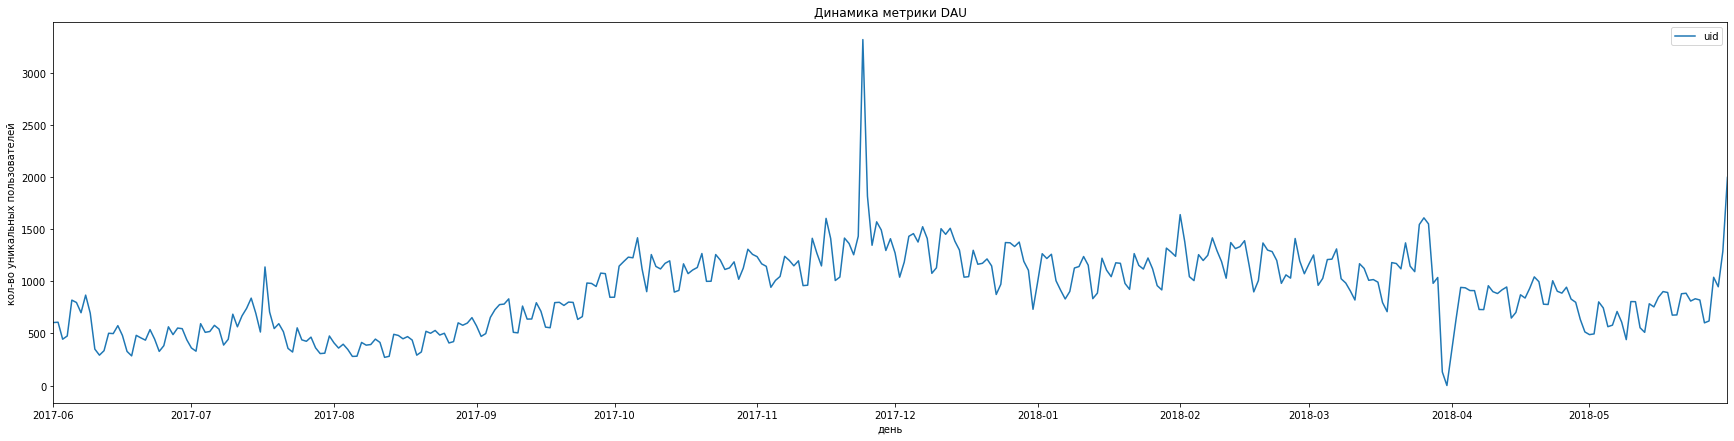

In [24]:
visits.groupby(['session_date']).agg({'uid': 'nunique'}).plot( figsize = (30,7))
plt.title('Динамика метрики DAU')
plt.ylabel('кол-во уникальных пользователей')
plt.xlabel('день');

На данном графике видна периодичность подъемов и спадов в зав-ти от дня. Так же мы видим резкий рост, это связано с маркетинговой акцией-распродажей "черная пятница". А падение до нуля в конце марта может быть связано с техническими неполадками на сайте. Рассмотрим эту периодичность от дня недели.

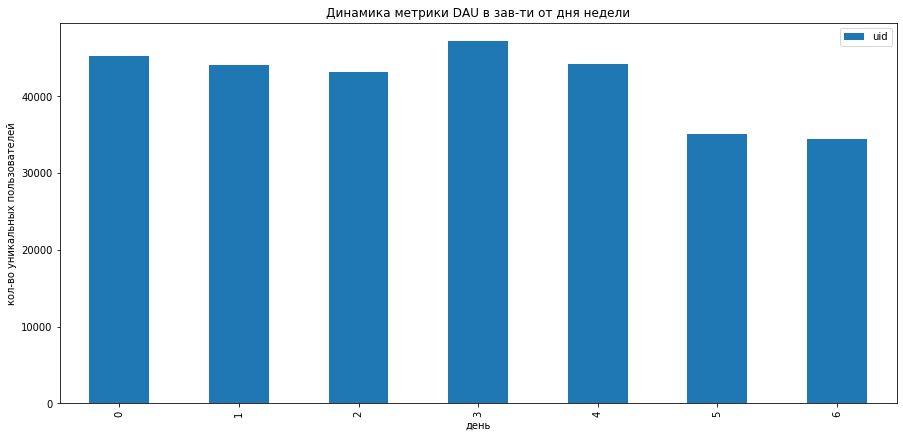

In [25]:
visits.groupby(['session_weekday']).agg({'uid': 'nunique'}).plot(kind = 'bar', figsize = (15,7))
plt.title('Динамика метрики DAU в зав-ти от дня недели')
plt.ylabel('кол-во уникальных пользователей')
plt.xlabel('день');

Рост посещений сайта зафиксирован в начале недели, а максимальное число приходится на четверг. Далее кол-во посещений снижается и в воскресенье становится минимально.

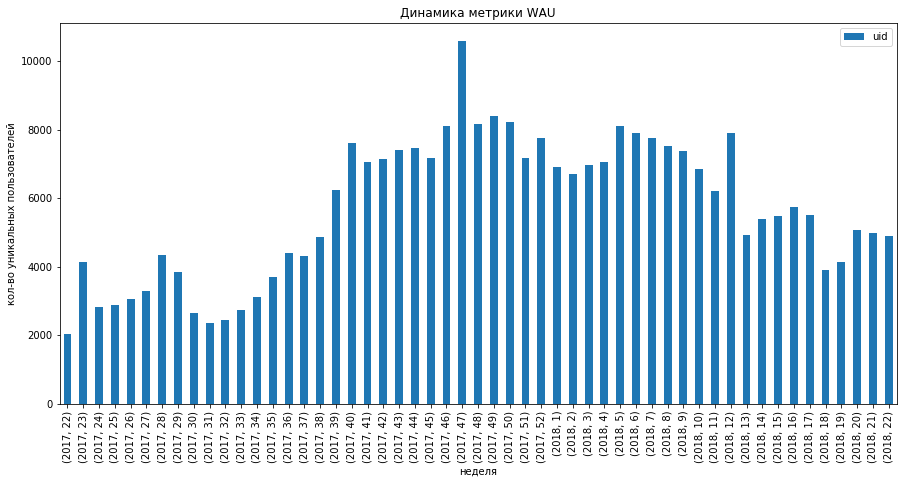

In [26]:
visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).plot(kind = 'bar', figsize = (15,7))
plt.title('Динамика метрики WAU')
plt.ylabel('кол-во уникальных пользователей')
plt.xlabel('неделя');

Самый низкий уровень метрики приходится на 31 неделю 2017 года. Это август. Т.е. наблюдается корреляция с сезоном. В летний сезон многие театры уходят в отпуск, поэтому и спрос на Афишу становится ниже.
максимальное значение метрики приходится на 47 неделю - это конец ноября. Затем распределение находится на стабильно высоком уровне, а к 1 неделе 2018 года - падает. Полоучается, что спрос есть перед новогодними празниками, а затем он снижается.

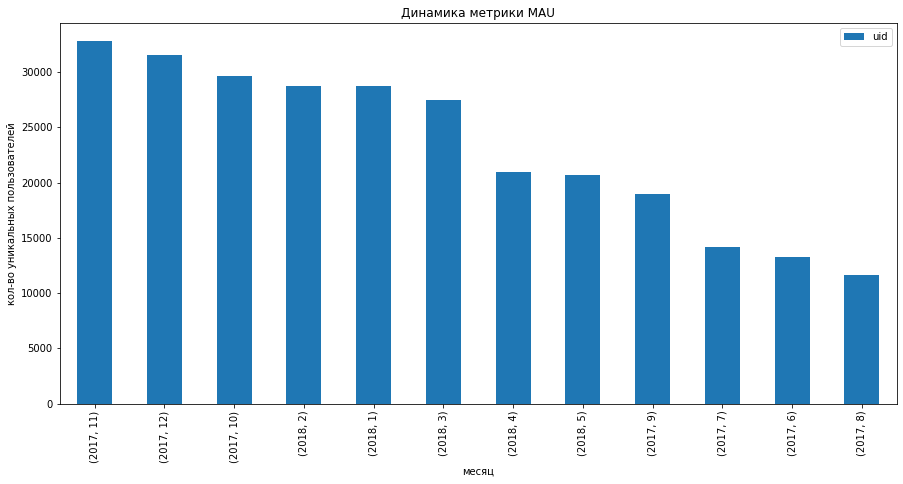

In [27]:
visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).sort_values(by = 'uid', ascending = False).plot(kind = 'bar', figsize = (15,7))
plt.title('Динамика метрики MAU')
plt.ylabel('кол-во уникальных пользователей')
plt.xlabel('месяц');

Наибольшее кол-во уникальных пользователей приходится на декабрь и январь и минимальное на август.

#### Количество посещений в день.

In [28]:
#чтобы найти эту метрику необходимо разделить число сессий на количество пользователей за период
sessions_per_user = visits.groupby(['session_year', 'session_date']).agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
display(sessions_per_user.head(10)) 

n_sessions  n_users  sessions_per_user
session_year session_date                                        
2017         2017-06-01           664      605           1.097521
             2017-06-02           658      608           1.082237
             2017-06-03           477      445           1.071910
             2017-06-04           510      476           1.071429
             2017-06-05           893      820           1.089024
             2017-06-06           875      797           1.097867
             2017-06-07           788      699           1.127325
             2017-06-08           939      868           1.081797
             2017-06-09           755      695           1.086331
             2017-06-10           375      350           1.071429

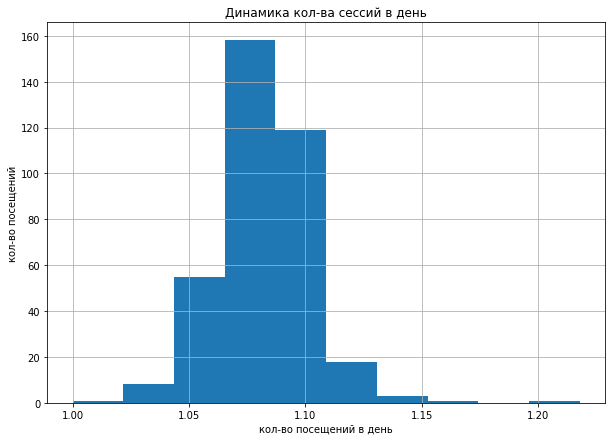

In [29]:
sessions_per_user['sessions_per_user'].hist(bins = 10, figsize = (10,7) )
plt.title('Динамика кол-ва сессий в день')
plt.ylabel('кол-во посещений')
plt.xlabel('кол-во посещений в день');

По гистограмме видно, что чаще всего пользователи заходят на сайт чуть больше, чем 1 раз.

#### Исследование продолжительности сессии.

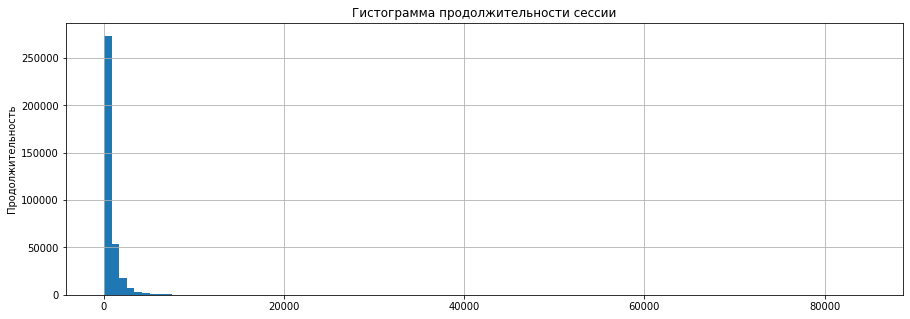

In [30]:
#Рассмотрим распределение
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins = 100,figsize = (15, 5), grid = True)
plt.title('Гистограмма продолжительности сессии')
plt.ylabel('Продолжительность');

In [31]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [32]:
print('Средняя продолжительность сессии:', visits['session_duration_sec'].mean()) 

Средняя продолжительность сессии: 643.506488592098


In [33]:
print('Медианная продолжительность сессии:', visits['session_duration_sec'].median()) 

Медианная продолжительность сессии: 300.0


In [34]:
#Распределение не является нормальным, поэтому рассчитаем значение, которое встречается чаще всего - моду:
print('Мода продолжительности сессии:', visits['session_duration_sec'].mode()) 

Мода продолжительности сессии: 0    60
dtype: int64


Чаще всего пользователи проводят на сайте 60 секунд.

#### Рассчиет Retention Rate при помощи когортного анализа.

In [35]:
#воспользуемся когортами, сформированными по месяцам первого использования сайта
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
#объединим датасет с исходным visits
visits = visits.join(first_activity_date,on='uid') 
print(visits.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year  session_month  session_week  \
0  16879256277535980062          2017             12            51   
1    104060357244891740          2018              2             8   
2   7459035603376831527          2017              7            26   
3  16174680259334210214          2018              5            20   
4   9969694820036681168          2017             12            52   

   session_weekday session_date  session_duration_sec first_activity_date  
0                2   2017-12-20                  1080 2017-12-20 17:20:00  
1                0   2018-02-19     

В исходном датасете появился столбец с датой первой активности пользователя

In [36]:
#сфрмируем когорты по месяцу первой активности
#добавим столбец с номером месяца первой активности, он станет идентификатом
visits['first_visits_month'] = visits['first_activity_date'].astype('datetime64[M]')
#добавим столбец с номером месяца активности
visits['session_month'] = visits['session_date'].astype('datetime64[M]')

In [37]:
print(visits.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year session_month  session_week  \
0  16879256277535980062          2017    2017-12-01            51   
1    104060357244891740          2018    2018-02-01             8   
2   7459035603376831527          2017    2017-07-01            26   
3  16174680259334210214          2018    2018-05-01            20   
4   9969694820036681168          2017    2017-12-01            52   

   session_weekday session_date  session_duration_sec first_activity_date  \
0                2   2017-12-20                  1080 2017-12-20 17:20:00   
1                0   2018-02-19         

In [38]:
#рассчитаем лайфтам когорты в месяцах
visits['cohort_lifetime'] = (visits['session_month'] - visits['first_visits_month'])
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')

print(visits.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year session_month  session_week  \
0  16879256277535980062          2017    2017-12-01            51   
1    104060357244891740          2018    2018-02-01             8   
2   7459035603376831527          2017    2017-07-01            26   
3  16174680259334210214          2018    2018-05-01            20   
4   9969694820036681168          2017    2017-12-01            52   

   session_weekday session_date  session_duration_sec first_activity_date  \
0                2   2017-12-20                  1080 2017-12-20 17:20:00   
1                0   2018-02-19         

In [39]:
#Сгруппируем данные по когорте и lifetime. 
#Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»
cohorts = visits.groupby(['first_visits_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
print(cohorts.head())

  first_visits_month  cohort_lifetime    uid
0         2017-06-01                0  13259
1         2017-06-01                1   1043
2         2017-06-01                2    713
3         2017-06-01                3    814
4         2017-06-01                4    909


In [40]:
#Найдём исходное количество пользователей в когорте. 
#Возьмём их число на нулевой месяц:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visits_month', 'uid']]
print(initial_users_count) 

   first_visits_month    uid
0          2017-06-01  13259
12         2017-07-01  13140
23         2017-08-01  10181
33         2017-09-01  16704
42         2017-10-01  25977
50         2017-11-01  27248
57         2017-12-01  25268
63         2018-01-01  22624
68         2018-02-01  22197
72         2018-03-01  20589
75         2018-04-01  15709
77         2018-05-01  15273


In [41]:
#переименуем столбец 'uid'
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
print(initial_users_count.head())

   first_visits_month  cohort_users
0          2017-06-01         13259
12         2017-07-01         13140
23         2017-08-01         10181
33         2017-09-01         16704
42         2017-10-01         25977


In [42]:
#Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(initial_users_count,on='first_visits_month') 
print(cohorts.head())

  first_visits_month  cohort_lifetime    uid  cohort_users
0         2017-06-01                0  13259         13259
1         2017-06-01                1   1043         13259
2         2017-06-01                2    713         13259
3         2017-06-01                3    814         13259
4         2017-06-01                4    909         13259


In [43]:
#рассчитаем retention: 
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
cohorts['first_visits_month'] = cohorts['first_visits_month'].astype('str')

In [44]:
#построим сводную таблицу
retention_pivot = cohorts.pivot_table(index='first_visits_month', columns='cohort_lifetime', values='retention', aggfunc='sum') 

In [45]:
print(retention_pivot)

cohort_lifetime      0         1         2         3         4         5   \
first_visits_month                                                          
2017-06-01          1.0  0.078664  0.053775  0.061392  0.068557  0.071423   
2017-07-01          1.0  0.056088  0.051294  0.056164  0.058219  0.048174   
2017-08-01          1.0  0.076908  0.062862  0.062764  0.050093  0.044004   
2017-09-01          1.0  0.085489  0.069205  0.050706  0.039392  0.037835   
2017-10-01          1.0  0.078608  0.052239  0.038958  0.034261  0.032221   
2017-11-01          1.0  0.078281  0.044113  0.038682  0.033727  0.023415   
2017-12-01          1.0  0.055802  0.037993  0.031107  0.020263  0.019036   
2018-01-01          1.0  0.059715  0.039339  0.024973  0.020244       NaN   
2018-02-01          1.0  0.057080  0.025454  0.020093       NaN       NaN   
2018-03-01          1.0  0.041818  0.027053       NaN       NaN       NaN   
2018-04-01          1.0  0.048380       NaN       NaN       NaN       NaN   

In [46]:
del retention_pivot[0]

In [47]:
print(retention_pivot)

cohort_lifetime           1         2         3         4         5   \
first_visits_month                                                     
2017-06-01          0.078664  0.053775  0.061392  0.068557  0.071423   
2017-07-01          0.056088  0.051294  0.056164  0.058219  0.048174   
2017-08-01          0.076908  0.062862  0.062764  0.050093  0.044004   
2017-09-01          0.085489  0.069205  0.050706  0.039392  0.037835   
2017-10-01          0.078608  0.052239  0.038958  0.034261  0.032221   
2017-11-01          0.078281  0.044113  0.038682  0.033727  0.023415   
2017-12-01          0.055802  0.037993  0.031107  0.020263  0.019036   
2018-01-01          0.059715  0.039339  0.024973  0.020244       NaN   
2018-02-01          0.057080  0.025454  0.020093       NaN       NaN   
2018-03-01          0.041818  0.027053       NaN       NaN       NaN   
2018-04-01          0.048380       NaN       NaN       NaN       NaN   
2018-05-01               NaN       NaN       NaN       NaN      

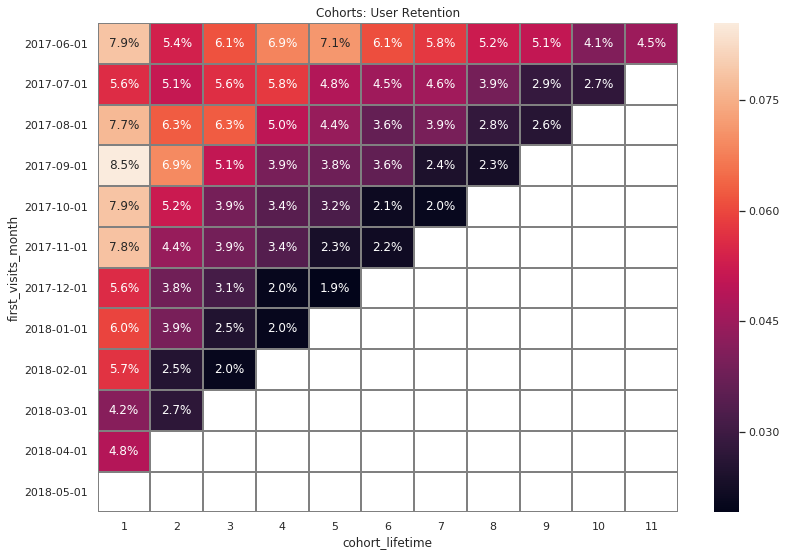

In [48]:
# построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Коэффициент удержания очень низкий, тенденция к снижению численности с течением времени видна у всех когорт.

In [49]:
retention_pivot = retention_pivot.reset_index()

In [50]:
retention_pivot

cohort_lifetime,first_visits_month,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
1,2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2,2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
3,2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
4,2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
5,2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
6,2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-03-01,0.041818,0.027053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#расчет среднего Retention Rate на 2 месяц жизни когорт:
r = (retention_pivot.loc[:, 2].mean() * 100).round(2)
print('Cредний Retention Rate на 2 месяц жизни когорт:', r, '%')

Cредний Retention Rate на 2 месяц жизни когорт: 4.63 %


### Расчет метрик электронной коммерции

#### Исследование среднего времени с момента первого посещения сайта до совершения покупки. 

In [52]:
display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_weekday,session_date,session_duration_sec,first_activity_date,first_visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,0,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,5,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,6,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,0


In [53]:
#сгруппируем данные из датафрейма visits по уникальному номеру пользователя, выделим первое посещение сайта
first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_visits']
print(first_visits.head()) 

               uid        first_visits
0   11863502262781 2018-03-01 17:27:00
1   49537067089222 2018-02-06 15:55:00
2  297729379853735 2017-06-07 18:47:00
3  313578113262317 2017-09-18 22:49:00
4  325320750514679 2017-09-30 14:29:00


In [54]:
#присоединим таблицу orders к first_visits по столбцу uid
first_visits = first_visits.merge(orders, on = 'uid')

In [55]:
print(first_visits.head())

                uid        first_visits              buy_ts  revenue
0   313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00     0.55
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00     1.22
2  1575281904278712 2017-06-03 10:13:00 2017-06-03 17:39:00     1.83
3  2429014661409475 2017-10-11 17:14:00 2017-10-11 18:33:00    73.33
4  2464366381792757 2018-01-27 20:10:00 2018-01-28 15:54:00     2.44


In [56]:
#рассчитаем время от первого посещения сайта до совершения покупки
first_visits['order_time'] = (first_visits['buy_ts'] - first_visits['first_visits']).dt.seconds

In [57]:
print(first_visits.head())

                uid        first_visits              buy_ts  revenue  \
0   313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00     0.55   
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00     1.22   
2  1575281904278712 2017-06-03 10:13:00 2017-06-03 17:39:00     1.83   
3  2429014661409475 2017-10-11 17:14:00 2017-10-11 18:33:00    73.33   
4  2464366381792757 2018-01-27 20:10:00 2018-01-28 15:54:00     2.44   

   order_time  
0       82920  
1           0  
2       26760  
3        4740  
4       71040  


In [58]:
first_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 5 columns):
uid             50415 non-null uint64
first_visits    50415 non-null datetime64[ns]
buy_ts          50415 non-null datetime64[ns]
revenue         50415 non-null float64
order_time      50415 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(1), uint64(1)
memory usage: 2.3 MB


In [59]:
first_visits['order_time'].describe()

count    50415.000000
mean     21482.556382
std      29056.969172
min          0.000000
25%        360.000000
50%       3840.000000
75%      39000.000000
max      86340.000000
Name: order_time, dtype: float64

In [60]:
#посчитаю сколько строк, где order_time равен 0
print('Строк с нулевым значением order_time = ', first_visits.query('order_time == 0')['order_time'].count())

Строк с нулевым значением order_time =  2486


Т.к. всего в датафрейме 50415, для более корректного рассчета исключу стоки с order_time = 0

In [61]:
first_visits.query('order_time > 0')['order_time'].describe()

count    47929.000000
mean     22596.821966
std      29375.531522
min         60.000000
25%        480.000000
50%       5160.000000
75%      42960.000000
max      86340.000000
Name: order_time, dtype: float64

Минимальное время, которое проходит с момента первохо входа на сайт до офомления заказа = 60 секунд.

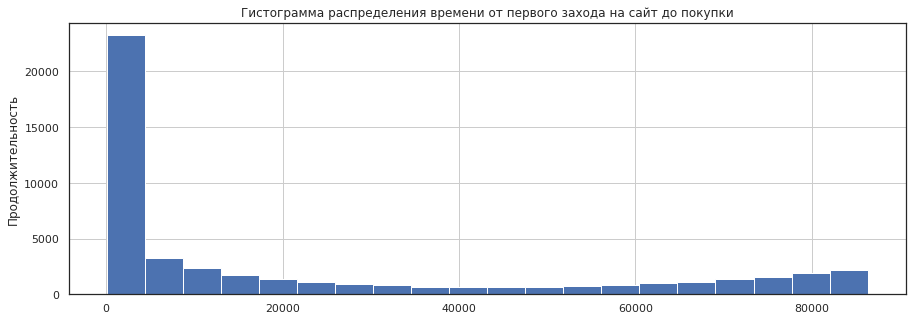

In [62]:
#посмотрим распределение на гистограмме
first_visits.query('order_time > 0')['order_time'].hist(bins = 20, figsize = (15, 5), grid = True)
plt.title('Гистограмма распределения времени от первого захода на сайт до покупки')
plt.ylabel('Продолжительность');

Т.к. распределение не похоже на нормальное, необходимо истользовать моду.

In [63]:
print('Мода интервала времени с момента первого посещения сайта до совершения покупки (сек):', 
    first_visits.query('order_time > 0')['order_time'].mode())

Мода интервала времени с момента первого посещения сайта до совершения покупки (сек): 0    60
dtype: int64


In [64]:
print('Кол-во значений, равных 60 сек:', 
    first_visits.query('order_time == 60')['order_time'].count())

Кол-во значений, равных 60 сек: 2687


In [65]:
print('Кол-во строк', len(first_visits.query('order_time > 0')))

Кол-во строк 47929


#### Рассчитайте среднее количество покупок на одного покупателя

In [66]:
#рассчитаю таким образом:
#найду кол-во покупателей 
#найду кол-во уникальных покупателей
#разделю первый параметр на второй

In [67]:
print(orders.head())

               buy_ts  revenue                   uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450


In [68]:
bayers = orders['uid'].count()
bayers_unique = orders['uid'].nunique()
count_orders = bayers / bayers_unique
print('Кол-во покупок на одного пользователя: {:.2f}'.format(count_orders))

Кол-во покупок на одного пользователя: 1.38


#### Рассчет среднего чека в зависимости от месяца совершения покупки.

In [69]:
display(orders.head())
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [70]:
mean_receipt = orders.groupby(['order_month'])['revenue'].mean().reset_index()

In [71]:
print(mean_receipt)
mean_receipt['order_month'] = mean_receipt['order_month'].astype('str')

   order_month   revenue
0   2017-06-01  4.060106
1   2017-07-01  5.306589
2   2017-08-01  4.847139
3   2017-09-01  5.416448
4   2017-10-01  4.928280
5   2017-11-01  4.783518
6   2017-12-01  5.852139
7   2018-01-01  4.112927
8   2018-02-01  4.840095
9   2018-03-01  5.413930
10  2018-04-01  5.150645
11  2018-05-01  4.771279
12  2018-06-01  3.420000


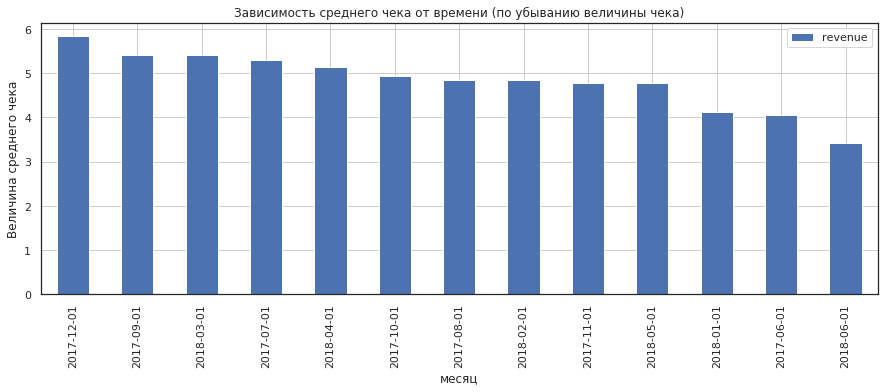

In [72]:
mean_receipt.sort_values(by = 'revenue', ascending = False).plot(kind = 'bar', x = 'order_month', y = 'revenue', figsize = (15, 5), grid = True)
plt.title('Зависимость среднего чека от времени (по убыванию величины чека)')
plt.ylabel('Величина среднего чека')
plt.xlabel('месяц');

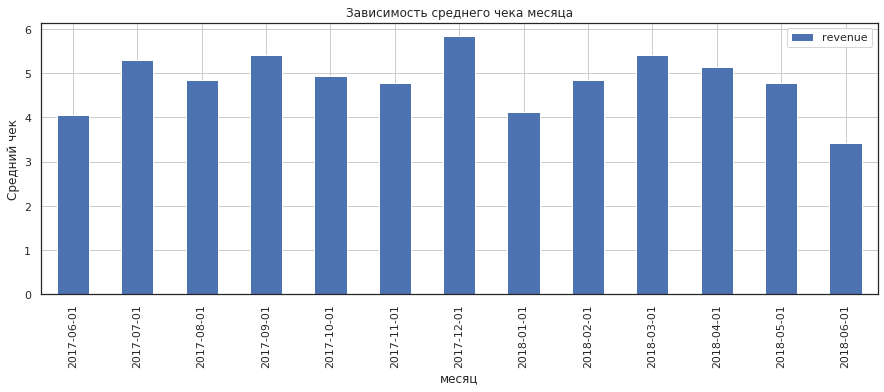

In [73]:
mean_receipt.plot(kind = 'bar', x = 'order_month', y = 'revenue', figsize = (15, 5), grid = True)
plt.title('Зависимость среднего чека месяца')
plt.ylabel('Средний чек')
plt.xlabel('месяц');

Из графика видно, что самые маленькие средние чеки приходятся на июнь (4.06 у.е) , а самый большой - на декабрь 2017 (5.85 у.е.).

#### Рассчет изменения LTV на покупателя по когортам при маржинальности = 100%.

In [74]:
print(orders.head())

               buy_ts  revenue                   uid order_month
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01


In [75]:
#в таблицу расходов добавим столбец month
costs['month'] = costs['dt'].astype('datetime64[M]') 
print(costs.head())

   source_id         dt  costs      month
0          1 2017-06-01  75.20 2017-06-01
1          1 2017-06-02  62.25 2017-06-01
2          1 2017-06-03  36.53 2017-06-01
3          1 2017-06-04  55.00 2017-06-01
4          1 2017-06-05  57.08 2017-06-01


In [76]:
#Получим месяц первой покупки каждого покупателя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
print(first_orders.head()) 


                uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01


In [77]:
#Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes = (first_orders.groupby('first_order_month').agg(
    {'uid': 'nunique'}).reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes.head()) 



  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


In [78]:
#Построим когорты.
#Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = pd.merge(orders,first_orders, on='uid')
print(orders_new.head()) 


               buy_ts  revenue                   uid order_month  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   

  first_order_month  
0        2017-06-01  
1        2017-06-01  
2        2017-06-01  
3        2017-06-01  
4        2017-06-01  


In [79]:
# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа.
#добавим столбец общей выручки revenue
cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg(
    {'revenue': 'sum'}).reset_index()

print(cohorts.head())

  first_order_month order_month  revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58


Строка таблицы cohorts показывает, какую выручку принесла когорта.

In [80]:
print(cohort_sizes)

   first_order_month  n_buyers
0         2017-06-01      2023
1         2017-07-01      1923
2         2017-08-01      1370
3         2017-09-01      2581
4         2017-10-01      4340
5         2017-11-01      4081
6         2017-12-01      4383
7         2018-01-01      3373
8         2018-02-01      3651
9         2018-03-01      3533
10        2018-04-01      2276
11        2018-05-01      2988
12        2018-06-01         1


In [81]:
#LTV — накопительная выручка когорты в пересчёте на количество людей. 
#Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
print(report.head()) 


  first_order_month  n_buyers order_month  revenue
0        2017-06-01      2023  2017-06-01  9557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01  1931.30
4        2017-06-01      2023  2017-10-01  2068.58


In [82]:
#LTV считают не из выручки, а из валовой прибыли. Найдем найти валовую прибыль, умножив выручку на маржинальность (100%). 
#LTV — удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст когорты.
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
print(report.head()) 


  first_order_month  n_buyers order_month  revenue       gp  age
0        2017-06-01      2023  2017-06-01  9557.49  9557.49    0
1        2017-06-01      2023  2017-07-01   981.82   981.82    1
2        2017-06-01      2023  2017-08-01   885.34   885.34    2
3        2017-06-01      2023  2017-09-01  1931.30  1931.30    3
4        2017-06-01      2023  2017-10-01  2068.58  2068.58    4


In [83]:
report['ltv'] = report['gp'] / report['n_buyers']
display(report.head())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [84]:
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)
output = output.cumsum(axis=1).round(2) 


In [85]:
output.head()

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN


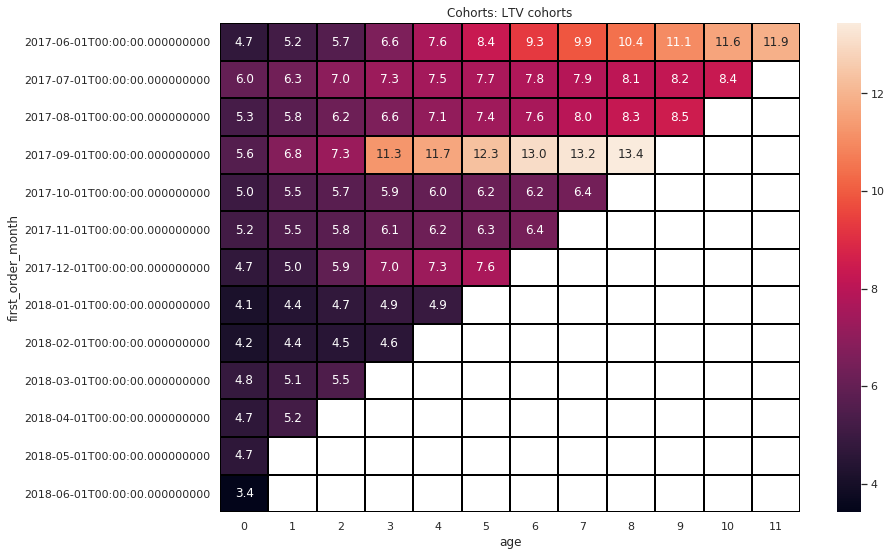

In [86]:
# построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV cohorts')
sns.heatmap(output, annot=True, fmt='.1f', linewidths=1, linecolor='black'); 

<div class="alert alert-block alert-warning">
<b>Комментарии от ревьюера:</b>

LTV рассчитан верно и тепловая карта оформлена правильно. Добавь пожалуйста еще средний LTV за 6 месяцев, чтобы исключить влияние "молодых" когорт
</div>

Параметр LTV растет с течением времени, это говорит о том, что прибыль с каждой когорты увеличивается.

<div class="alert alert-info"> 
<b>Комменатарий студента</b>
Расчет среднего ltv приведен ниже
</div>

In [87]:
output = output.reset_index()
display(output)
output.info()

age,first_order_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
1,2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2,2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
3,2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
4,2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
5,2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
6,2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-03-01,4.84,5.14,5.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 13 columns):
first_order_month    13 non-null datetime64[ns]
0                    13 non-null float64
1                    11 non-null float64
2                    10 non-null float64
3                    9 non-null float64
4                    8 non-null float64
5                    7 non-null float64
6                    6 non-null float64
7                    5 non-null float64
8                    4 non-null float64
9                    3 non-null float64
10                   2 non-null float64
11                   1 non-null float64
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.4 KB


In [88]:
#выделим только те когорты, время жизни которых больше 6 месяцев
cоhorts_6 = output.query('first_order_month < "2018-01-01"')

In [89]:
display(cоhorts_6)

age,first_order_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
1,2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2,2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
3,2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
4,2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
5,2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
6,2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
print('Средний ltv когорт с lifetime более 6 месяцев', cоhorts_6.mean())

Средний ltv когорт с lifetime более 6 месяцев age
0      5.220000
1      5.737143
2      6.215714
3      7.250000
4      7.634286
5      7.970000
6      8.388333
7      9.082000
8     10.062500
9      9.250000
10    10.005000
11    11.880000
dtype: float64


In [91]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [92]:
#расчитаем CAC по когортам
monthly_costs_cohorts = costs.groupby('month').sum()
monthly_costs_cohorts.head() 

,source_id,costs
month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88


In [93]:
#добавим данные о расходах в отчет и посчитаем CAC
report_cohorts = pd.merge(
    report, monthly_costs_cohorts, left_on='first_order_month', right_on='month'
)
report_cohorts['cac'] = report_cohorts['costs'] / report_cohorts['n_buyers']
report_cohorts.head() 

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,1020,18015.0,8.905091


In [94]:
#рассчитаем ROMI
report_cohorts['romi'] = report_cohorts['ltv'] / report_cohorts['cac']
output_cohorts = report_cohorts.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

output_cohorts.cumsum(axis=1).round(2) 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из всех когорт окупились только первая (к 6 месяцу жизни) и четвертая (к третьему месяцу жизни)

In [95]:
#На практике считают среднюю когорту — усредняют ROMI или LTV всех когорт за каждый месяц их жизни. 
#Узнаем, как быстро в среднем когорты окупаются.
output_cohorts.cumsum(axis=1).mean(axis=0) 

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем когорты окупаются к 8 месяцу жизни.

### Расчет маркетинговых метрик

In [96]:
print(costs.head())

   source_id         dt  costs      month
0          1 2017-06-01  75.20 2017-06-01
1          1 2017-06-02  62.25 2017-06-01
2          1 2017-06-03  36.53 2017-06-01
3          1 2017-06-04  55.00 2017-06-01
4          1 2017-06-05  57.08 2017-06-01


#### Рассчет общих расходов на маркетинг. 

In [97]:
#общие расходы
costs_all = costs['costs'].sum()
print('Общие расходы на маркетинг:', costs_all )


Общие расходы на маркетинг: 329131.62


In [98]:
# расходы по источникам
costs_source = costs.groupby('source_id')['costs'].sum().reset_index()
print(costs_source)

   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


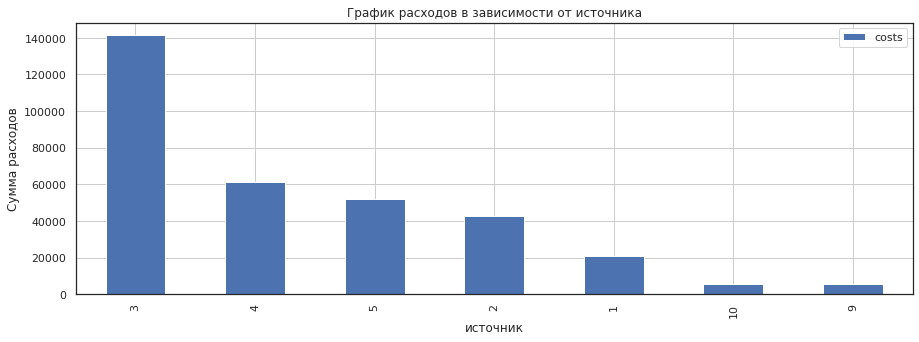

In [99]:
costs_source.sort_values(by = 'costs', ascending = False).plot(kind = 'bar', x = 'source_id', y = 'costs', figsize = (15, 5), grid = True)
plt.title('График расходов в зависимости от источника')
plt.ylabel('Сумма расходов')
plt.xlabel('источник');

Самые большие расходы на источник с ID = 3

In [100]:
# посчитаем расходы по месяцам, добавим столбец с номером месяца
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()
print(monthly_costs)

        month     costs
0  2017-06-01  18015.00
1  2017-07-01  18240.59
2  2017-08-01  14790.54
3  2017-09-01  24368.91
4  2017-10-01  36322.88
5  2017-11-01  37907.88
6  2017-12-01  38315.35
7  2018-01-01  33518.52
8  2018-02-01  32723.03
9  2018-03-01  30415.27
10 2018-04-01  22289.38
11 2018-05-01  22224.27


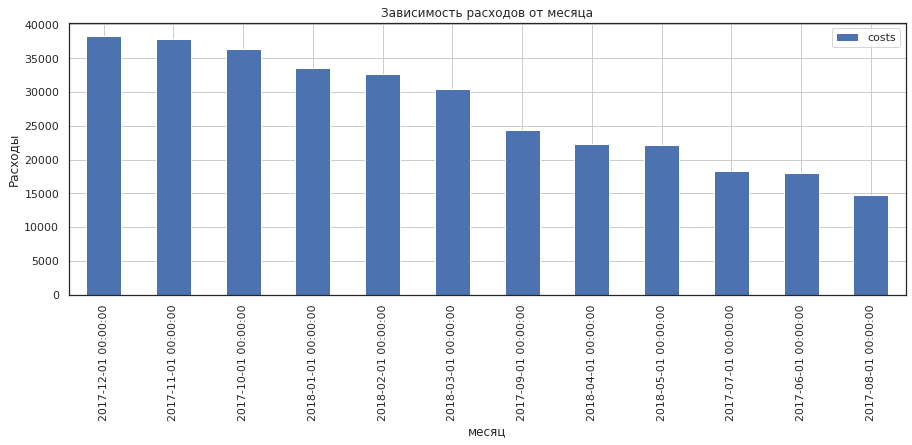

In [101]:
monthly_costs.sort_values(by = 'costs', ascending = False).plot(kind = 'bar', x = 'month', y = 'costs', figsize = (15, 5), grid = True)
plt.title('Зависимость расходов от месяца')
plt.ylabel('Расходы')
plt.xlabel('месяц');

Самые большие расходы в декабре и ноябре.

<div class="alert alert-block alert-success">
<b>Комментарии от ревьюера:</b>

Всё верно. Наглядные графики и корректный расчеты. Молодец)
</div>

#### Рассчет среднего CAC на одного покупателя для всего проекта и для каждого источника трафика. 

In [102]:
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [103]:
orders['start_date'] = orders['buy_ts'].astype('datetime64[D]')
print(orders.head())

               buy_ts  revenue                   uid order_month start_date
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01 2017-06-01
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01 2017-06-01
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01 2017-06-01
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01 2017-06-01
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01 2017-06-01


In [104]:
#создам таблицу, где каждому пользователю будет соответвовать дата первого заказа
first_order = orders.groupby('uid').agg({'start_date':'min'}).reset_index()
first_order.columns = ['uid', 'first_order']
print(first_order.head())

                uid first_order
0   313578113262317  2018-01-03
1  1575281904278712  2017-06-03
2  2429014661409475  2017-10-11
3  2464366381792757  2018-01-28
4  2551852515556206  2017-11-24


In [105]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_weekday,session_date,session_duration_sec,first_activity_date,first_visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,0,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,5,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,6,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,0


In [106]:
#создам таблицу с первыми источниками (каждому uid соответвует номер источника)
first_sources = visits.sort_values('start_ts').groupby('uid')['source_id'].first()
print(first_sources.head())
#print(len(first_sources))

uid
11863502262781     3
49537067089222     2
297729379853735    3
313578113262317    2
325320750514679    5
Name: source_id, dtype: int64


In [107]:
df = first_order.merge(first_sources, on = 'uid')

In [108]:
print(df.head())
#print(len(df))

                uid first_order  source_id
0   313578113262317  2018-01-03          2
1  1575281904278712  2017-06-03         10
2  2429014661409475  2017-10-11          3
3  2464366381792757  2018-01-28          5
4  2551852515556206  2017-11-24          5


In [109]:
df['first_order_month'] = df['first_order'].astype('datetime64[M]')

In [110]:
#группировка по иcточнику и дате, подсчет кол-ва покупателей
bayers = df.groupby(['source_id', 'first_order']).agg({'uid':'count'}).reset_index()
bayers.columns = ['source_id', 'first_order', 'bayers']
print(bayers.head())
#print(len(bayers))

   source_id first_order  bayers
0          1  2017-06-01      14
1          1  2017-06-02       7
2          1  2017-06-03       7
3          1  2017-06-04       3
4          1  2017-06-05      18


In [111]:
display(costs.head())
#print(len(costs))

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [112]:
df_2 = pd.merge(bayers, costs, right_on = ['source_id', 'dt'], left_on = ['source_id', 'first_order'] )

In [113]:
print(df_2.head())
#print(len(df_2))

   source_id first_order  bayers         dt  costs      month
0          1  2017-06-01      14 2017-06-01  75.20 2017-06-01
1          1  2017-06-02       7 2017-06-02  62.25 2017-06-01
2          1  2017-06-03       7 2017-06-03  36.53 2017-06-01
3          1  2017-06-04       3 2017-06-04  55.00 2017-06-01
4          1  2017-06-05      18 2017-06-05  57.08 2017-06-01


In [114]:
#CAC на одного покупателя = все расходы / на общее число пользователей
df_2['CAC'] = df_2['costs'] / df_2['bayers']

In [115]:
print(df_2.head())
#print(len(df_2))

   source_id first_order  bayers         dt  costs      month        CAC
0          1  2017-06-01      14 2017-06-01  75.20 2017-06-01   5.371429
1          1  2017-06-02       7 2017-06-02  62.25 2017-06-01   8.892857
2          1  2017-06-03       7 2017-06-03  36.53 2017-06-01   5.218571
3          1  2017-06-04       3 2017-06-04  55.00 2017-06-01  18.333333
4          1  2017-06-05      18 2017-06-05  57.08 2017-06-01   3.171111


In [116]:
#costs для каждого источника трафика
costs_source = df_2.groupby('source_id')['CAC'].mean().reset_index()
print(costs_source)

   source_id        CAC
0          1   9.489732
1          2  16.287024
2          3  15.580474
3          4   7.271743
4          5   8.336731
5          9   6.842532
6         10   6.555415


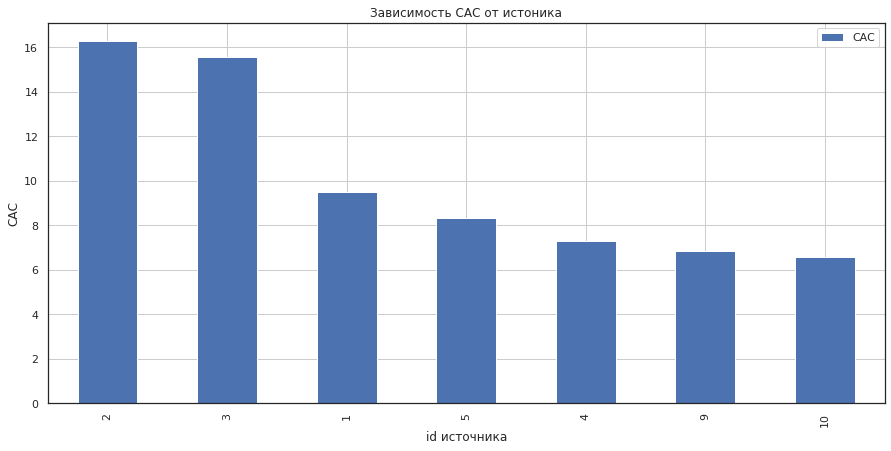

In [117]:
costs_source.sort_values(by = 'CAC', ascending = False).plot(
    kind = 'bar', x = 'source_id', grid = True, figsize = (15, 7))
plt.title('Зависимость CAC от истоника')
plt.ylabel('CAC')
plt.xlabel('id источника');

Наибольшая стоимость привлечения клиента у источника 2. 

#### Рассчет ROMI по когортам в разрезе источников.

In [118]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_weekday,session_date,session_duration_sec,first_activity_date,first_visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,0,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,5,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,6,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,0


In [119]:
#выделим номер первого источника для каждого uid
#чтобы кажому пользователю присвоить номер источника необходимо
#отсортировать визиты по start_ts, сгруппировать по uid, взять first
first_sources_1 = visits.sort_values(by = 'start_ts').groupby(
    'uid')['source_id'].first().reset_index()

In [120]:
print(first_sources_1.head())
#Получили таблицу, где каждому пользователю соответсвует номер источника

               uid  source_id
0   11863502262781          3
1   49537067089222          2
2  297729379853735          3
3  313578113262317          2
4  325320750514679          5


In [121]:
orders.head()

,buy_ts,revenue,uid,order_month,start_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [122]:
#объединю таблицу first_sources_1 с таблицей orders
df_1 =  first_sources_1.merge(orders, on = 'uid')

In [123]:
print(df_1.head())
#в данной таблице кажому пользователю соответвуют: id источника, таймкод покупки,
#выручка, месяц заказа и дата первого заказа

                uid  source_id              buy_ts  revenue order_month  \
0   313578113262317          2 2018-01-03 21:51:00     0.55  2018-01-01   
1  1575281904278712         10 2017-06-03 10:13:00     1.22  2017-06-01   
2  1575281904278712         10 2017-06-03 17:39:00     1.83  2017-06-01   
3  2429014661409475          3 2017-10-11 18:33:00    73.33  2017-10-01   
4  2464366381792757          5 2018-01-28 15:54:00     2.44  2018-01-01   

  start_date  
0 2018-01-03  
1 2017-06-03  
2 2017-06-03  
3 2017-10-11  
4 2018-01-28  


In [124]:
bayers_1 = df_1.groupby(['order_month', 'source_id']).agg({'uid':'count'}).reset_index()
bayers_1.columns = ['month', 'source_id', 'bayers']

In [125]:
print(bayers_1.head())
#таблица, где каждому источнику соответвует кол-во уникальных покупателей в каждом месяце

       month  source_id  bayers
0 2017-06-01          1     268
1 2017-06-01          2     281
2 2017-06-01          3     704
3 2017-06-01          4     467
4 2017-06-01          5     447


In [126]:
revenue = df_1.groupby(['source_id', 'order_month']).agg({'revenue':'sum'}).reset_index()
revenue.columns = ['source_id', 'month', 'revenue']

In [127]:
revenue.head()

,source_id,month,revenue
0,1,2017-06-01,1378.70
1,1,2017-07-01,1581.68
2,1,2017-08-01,1441.49
3,1,2017-09-01,3071.61
4,1,2017-10-01,3621.82


In [128]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [129]:
costs_1 = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()

In [130]:
costs_1.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


In [131]:
df_romi = pd.merge(costs_1, bayers_1, on = ['source_id', 'month'])

In [132]:
print(df_romi.head())

   source_id      month    costs  bayers
0          1 2017-06-01  1125.61     268
1          1 2017-07-01  1072.88     261
2          1 2017-08-01   951.81     243
3          1 2017-09-01  1502.01     449
4          1 2017-10-01  2315.75     587


In [133]:
df_romi = df_romi.merge(revenue, on = ['source_id', 'month'])

In [134]:
print(df_romi.head())

   source_id      month    costs  bayers  revenue
0          1 2017-06-01  1125.61     268  1378.70
1          1 2017-07-01  1072.88     261  1581.68
2          1 2017-08-01   951.81     243  1441.49
3          1 2017-09-01  1502.01     449  3071.61
4          1 2017-10-01  2315.75     587  3621.82


In [135]:
df_romi['CAC'] = df_romi['costs'] / df_romi['bayers']

In [136]:
df_romi.head()

,source_id,month,costs,bayers,revenue,CAC
0,1,2017-06-01,1125.61,268,1378.70,4.200037
1,1,2017-07-01,1072.88,261,1581.68,4.110651
2,1,2017-08-01,951.81,243,1441.49,3.916914
3,1,2017-09-01,1502.01,449,3071.61,3.345234
4,1,2017-10-01,2315.75,587,3621.82,3.945060


In [137]:
margin_rate = 1
df_romi['gp'] = df_romi['revenue'] * margin_rate

In [138]:
df_romi['ltv'] = df_romi['gp'] / df_romi['bayers']

In [139]:
df_romi['romi'] = df_romi['ltv'] / df_romi['CAC']

In [144]:
df_romi.head()

,source_id,month,costs,bayers,revenue,CAC,gp,ltv,romi
0,1,2017-06-01,1125.61,268,1378.70,4.200037,1378.70,5.144403,1.224847
1,1,2017-07-01,1072.88,261,1581.68,4.110651,1581.68,6.060077,1.474238
2,1,2017-08-01,951.81,243,1441.49,3.916914,1441.49,5.932058,1.514472
3,1,2017-09-01,1502.01,449,3071.61,3.345234,3071.61,6.841002,2.045000
4,1,2017-10-01,2315.75,587,3621.82,3.945060,3621.82,6.170051,1.563994


In [141]:
output_1 = df_romi.pivot_table(
    index='source_id', columns='month', values='romi', aggfunc='sum')
display(output_1.cumsum(axis=1).round(2))
# усредним ROMI всех когорт за каждый месяц их жизни.
# print('Усредненный ROMI всех когорт за каждый месяц их жизни')
# display(output_1.cumsum(axis=1).mean(axis=0))

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1.22,2.70,4.21,6.26,7.82,9.26,10.44,11.60,12.67,14.72,16.56,18.26
2,0.43,1.23,1.74,2.55,3.65,4.53,5.48,6.19,7.66,9.67,10.81,12.75
3,0.36,0.78,1.10,1.57,1.96,2.34,2.71,3.03,3.38,3.77,4.14,4.67
4,0.56,1.37,1.94,2.54,3.47,4.80,5.78,6.55,7.55,8.68,9.73,10.84
5,0.73,1.59,2.56,3.72,4.68,5.30,7.76,8.50,9.49,10.32,10.99,11.68
9,0.85,1.64,2.83,3.93,5.26,6.33,7.32,8.02,9.06,10.48,11.33,12.37
10,0.73,1.30,2.10,2.53,3.44,4.22,4.76,5.25,5.95,7.25,7.98,9.22


Источник 1 окупился в первый месяц, все остальные источники, кроме 3, окупились к 2 месяцу

## ВЫВОД

**Расчет продуктовых метрик показал, что:**

<li> Среднее количество уникальных пользователей в день DAU = 907
Рост посещений сайта зафиксирован в начале недели, а максимальное число приходится на четверг. Далее кол-во посещений снижается и в воскресенье становится минимально.
<li> Среднее количество уникальных пользователей в неделю WAU = 5716
Самый низкий уровень метрики приходится на 31 неделю 2017 года. Это август. Т.е. наблюдается корреляция с сезоном. В летний сезон многие театры уходят в отпуск, поэтому и спрос на афишу становится ниже.
максимальное значение метрики приходится на 47 неделю - это конец ноября. Затем распределение находится на стабильно высоком уровне, а к 1 неделе 2018 года - падает. Полоучается, что спрос есть перед новогодними празниками, а затем он снижается.
<li> Среднее количество уникальных пользователей в месяц MAU = 23228
Наибоольшее кол-во уникальных пользователей приходится на декабрь и январь и минимальное на август.
    
Коэффициент удержания в когортах, сформированных по месяцам, очень низкий и падает с lifetime когорты . Это говорит о низкой возвращаемости пользователей сайта. Cредний Retention Rate на 2 месяц жизни когорт: 4.63 %
    
**Расчет метрик электронной коммерции:**
    
Чаще всего у пользователя в день 1 сессия продолжительностью 60 секунд, 

Минимальное время, которое проходит с момента первоuо входа на сайт до офомления заказа = 60 секунд. Это же значение является наиболее частым.
    
Медианное время, которое проходит с момента первого входа до момента покупки - 86 мин.
    
Кол-во покупок на одного пользователя: 1.38.

Самое маленькое значение средний чек принимает в на июне, а самое большое - на декабрь.

Итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок (LTV) растет с течением времени.

Из всех когорт окупились только первая (к 6 месяцу жизни) и четвертая (к третьему месяцу жизни), в среднем же когорта окупается к 8 месяцу жизни.
    
**Расчет маркетинговых метрик:**
    
Общая сумма расходов на маркетинг за весь период составила 329131.62, при этом расходы на одного покупателя в среднем составили 9.01 у.е. В разбивке по месяцам самые большие расходы на меркетинг были в ноябре и декабре 2017.